In [1]:
#!pip install yfinance pandas matplotlib numpy tensorflow

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
# Specify the stock symbol and date range
stock_symbol = "AMZN"
start_date = "2018-01-01"
end_date = "2024-01-31"

In [3]:
# Fetch stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Extract the closing prices
closing_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)


In [5]:
# Create training dataset
train_size = int(len(closing_prices_scaled) * 0.80)
train_data, test_data = closing_prices_scaled[0:train_size, :], closing_prices_scaled[train_size:len(closing_prices_scaled), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 60  # You can adjust this based on your needs
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [6]:
# Reshape data for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [8]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
37/37 [==============================] - 8s 73ms/step - loss: 0.0423
Epoch 2/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0033
Epoch 3/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0025
Epoch 4/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0024
Epoch 5/10
37/37 [==============================] - 2s 67ms/step - loss: 0.0024
Epoch 6/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0024
Epoch 7/10
37/37 [==============================] - 2s 51ms/step - loss: 0.0022
Epoch 8/10
37/37 [==============================] - 2s 51ms/step - loss: 0.0022
Epoch 9/10
37/37 [==============================] - 2s 52ms/step - loss: 0.0019
Epoch 10/10
37/37 [==============================] - 2s 57ms/step - loss: 0.0020


In [9]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


8/8 [==============================] - 0s 16ms/step


In [10]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

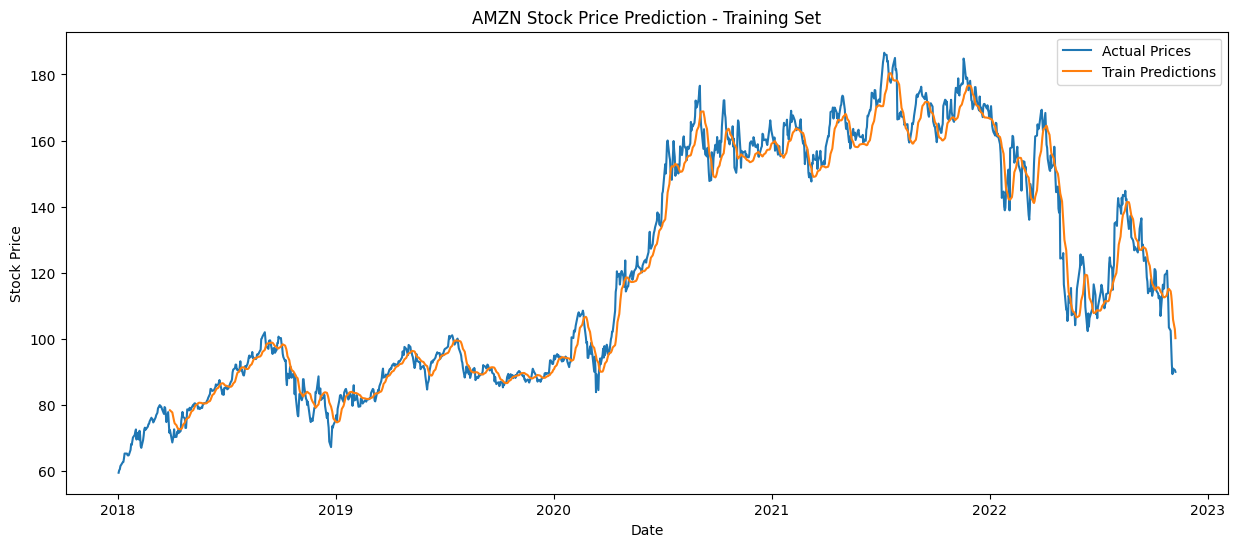

In [11]:
# Plot training set
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index[:train_size], closing_prices[:train_size], label='Actual Prices')
plt.plot(stock_data.index[time_steps:train_size], train_predict, label='Train Predictions')
plt.title(f'{stock_symbol} Stock Price Prediction - Training Set')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


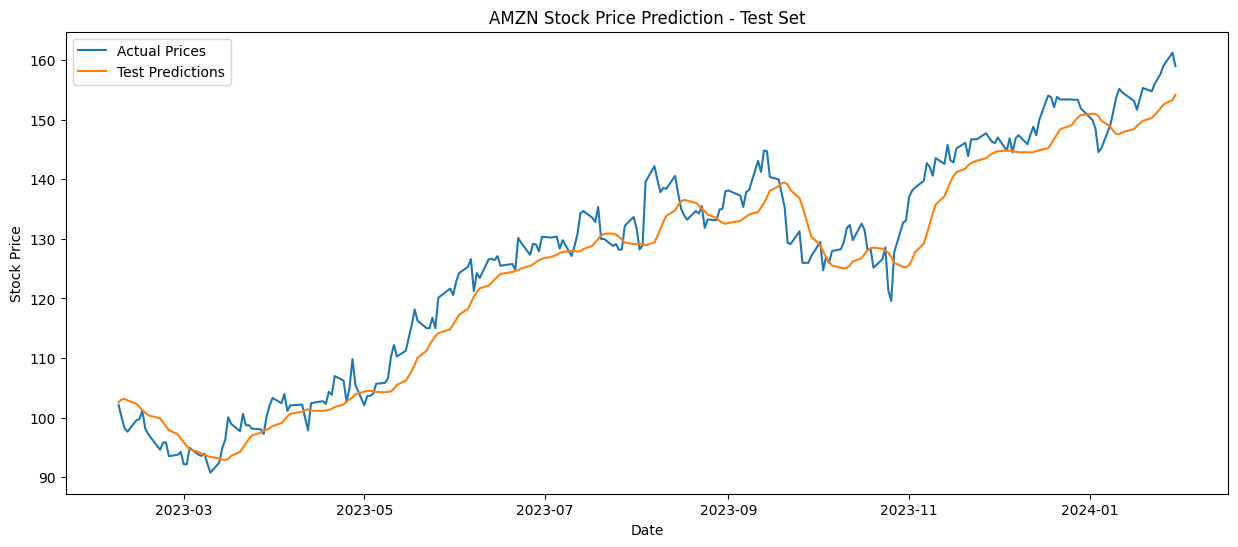

In [12]:
# Plot test set
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index[train_size + time_steps:], closing_prices[train_size + time_steps:], label='Actual Prices')
plt.plot(stock_data.index[train_size + time_steps:], test_predict, label='Test Predictions')
plt.title(f'{stock_symbol} Stock Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [13]:
# Extend the time frame to include future dates
end_date_future = "2024-12-31"
stock_data_future = yf.download(stock_symbol, start=start_date, end=end_date_future)

# Extract the closing prices
closing_prices_future = stock_data_future['Close'].values.reshape(-1, 1)

# Normalize the future data using the same scaler
closing_prices_future_scaled = scaler.transform(closing_prices_future)

# Create the extended training dataset
train_data_extended = np.concatenate((closing_prices_scaled, closing_prices_future_scaled), axis=0)

# Create the extended time series data for training
X_train_extended, y_train_extended = create_dataset(train_data_extended, time_steps)

[*********************100%%**********************]  1 of 1 completed


In [14]:
# Reshape data for LSTM input
X_train_extended = X_train_extended.reshape(X_train_extended.shape[0], X_train_extended.shape[1], 1)

# Build the LSTM model
model_extended = Sequential()
model_extended.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_extended.shape[1], 1)))
model_extended.add(LSTM(units=50))
model_extended.add(Dense(units=1))
model_extended.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Train the model on the extended dataset
model_extended.fit(X_train_extended, y_train_extended, epochs=10, batch_size=32)

# Make predictions for the future
future_time_steps = 250  # Adjust as needed
X_future = closing_prices_future_scaled[-time_steps:].reshape(1, -1)

future_predictions = []

for i in range(future_time_steps):
    prediction = model_extended.predict(X_future.reshape(1, time_steps, 1))
    future_predictions.append(prediction[0, 0])
    X_future = np.append(X_future[0, 1:], prediction[0]).reshape(1, -1)


Epoch 1/10
94/94 [==============================] - 9s 52ms/step - loss: 0.0174
Epoch 2/10
94/94 [==============================] - 7s 76ms/step - loss: 0.0032
Epoch 3/10
94/94 [==============================] - 5s 50ms/step - loss: 0.0029
Epoch 4/10
94/94 [==============================] - 6s 61ms/step - loss: 0.0024
Epoch 5/10
94/94 [==============================] - 5s 50ms/step - loss: 0.0021
Epoch 6/10
94/94 [==============================] - 5s 49ms/step - loss: 0.0020
Epoch 7/10
94/94 [==============================] - 6s 61ms/step - loss: 0.0017
Epoch 8/10
94/94 [==============================] - 5s 49ms/step - loss: 0.0016
Epoch 9/10
94/94 [==============================] - 6s 61ms/step - loss: 0.0015
Epoch 10/10
1/1 [==============================] - 0s 26ms/step


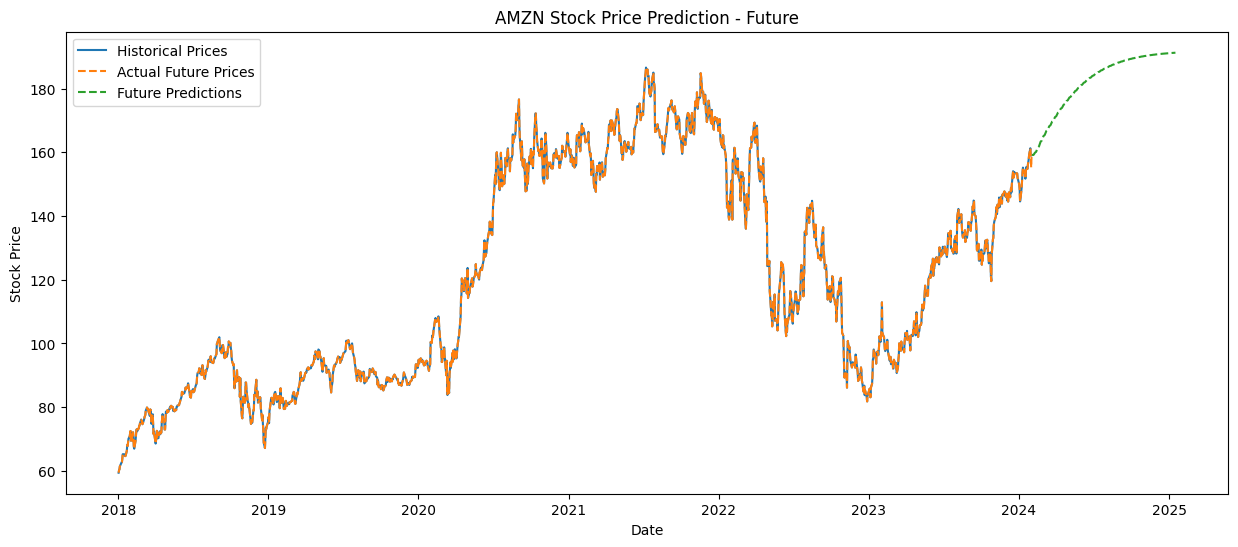

In [16]:
# Invert predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future predictions
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, closing_prices, label='Historical Prices')
plt.plot(stock_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=stock_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')
plt.title(f'{stock_symbol} Stock Price Prediction - Future')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [17]:
future_predictions


array([[159.20102],
       [159.13576],
       [159.21999],
       [159.38551],
       [159.60068],
       [159.85107],
       [160.12993],
       [160.43318],
       [160.75755],
       [161.09955],
       [161.45546],
       [161.82161],
       [162.19424],
       [162.56998],
       [162.94579],
       [163.31914],
       [163.68794],
       [164.05072],
       [164.40651],
       [164.75468],
       [165.09506],
       [165.4278 ],
       [165.75334],
       [166.0722 ],
       [166.38513],
       [166.69286],
       [166.99612],
       [167.2957 ],
       [167.59221],
       [167.88623],
       [168.17828],
       [168.46867],
       [168.75769],
       [169.0455 ],
       [169.33218],
       [169.61774],
       [169.90211],
       [170.18521],
       [170.4668 ],
       [170.74684],
       [171.02512],
       [171.30142],
       [171.57564],
       [171.84755],
       [172.11711],
       [172.38416],
       [172.64864],
       [172.91049],
       [173.16968],
       [173.42618],


In [18]:
# Calculate short-term and long-term moving averages
short_window = 20
long_window = 60

stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()

# Generate buy/sell signals based on moving average crossovers
stock_data['Signal'] = 0  # 0 represents no signal
stock_data['Signal'][short_window:] = np.where(stock_data['Short_MA'][short_window:] > stock_data['Long_MA'][short_window:], 1, 0)
stock_data['Position'] = stock_data['Signal'].diff()

<ipython-input-18-4a62619355ac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Signal'][short_window:] = np.where(stock_data['Short_MA'][short_window:] > stock_data['Long_MA'][short_window:], 1, 0)


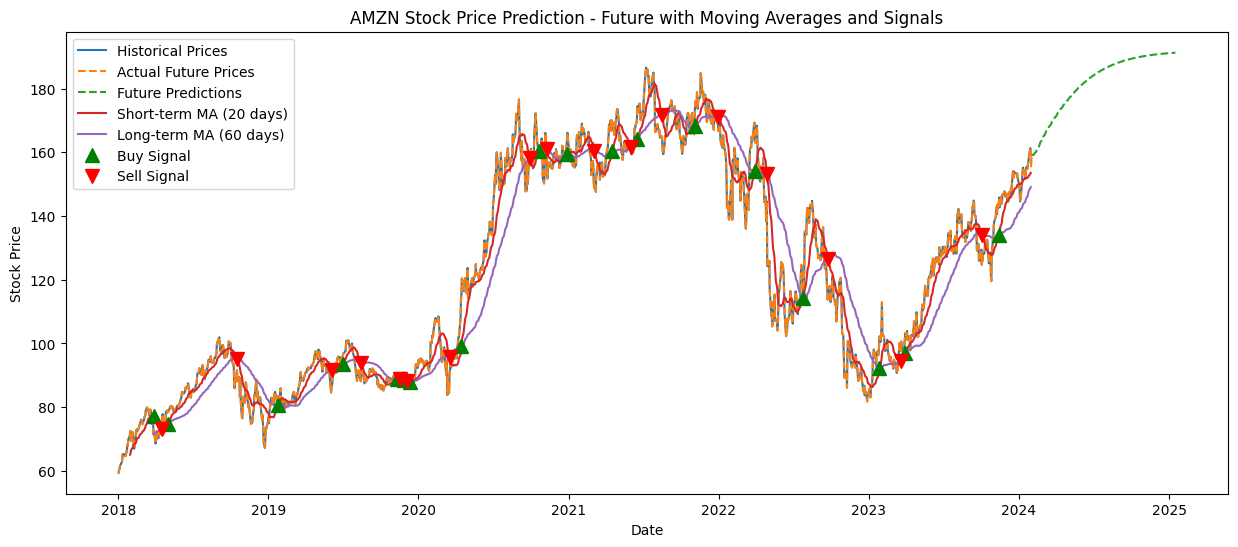

In [19]:
# Plot future predictions along with moving averages and signals
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, closing_prices, label='Historical Prices')
plt.plot(stock_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=stock_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')
plt.plot(stock_data.index, stock_data['Short_MA'], label=f'Short-term MA ({short_window} days)')
plt.plot(stock_data.index, stock_data['Long_MA'], label=f'Long-term MA ({long_window} days)')

# Plot buy signals (green) and sell signals (red)
plt.plot(stock_data[stock_data['Position'] == 1].index, stock_data['Short_MA'][stock_data['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(stock_data[stock_data['Position'] == -1].index, stock_data['Short_MA'][stock_data['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')

plt.title(f'{stock_symbol} Stock Price Prediction - Future with Moving Averages and Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

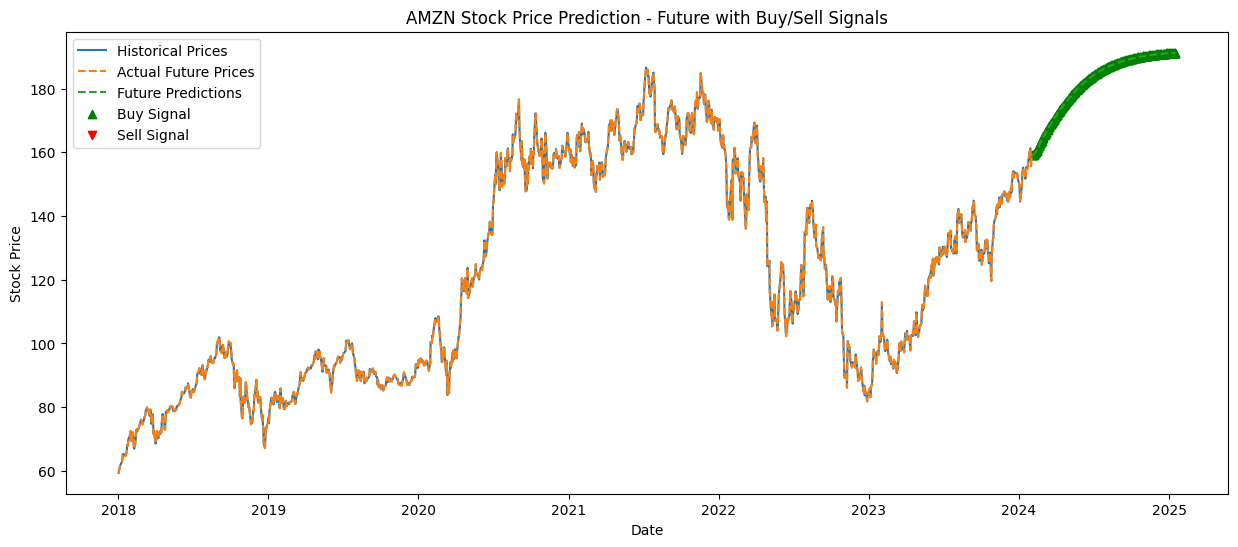

In [20]:
# Generate buy/sell signals based on future predictions
buy_threshold = 1.02  # Example threshold for a buy signal
sell_threshold = 0.98  # Example threshold for a sell signal

# Identify buy signals
buy_signals = np.where(future_predictions > buy_threshold, 1, 0)

# Identify sell signals
sell_signals = np.where(future_predictions < sell_threshold, -1, 0)

# Combine buy and sell signals
combined_signals = buy_signals + sell_signals

# Plot future predictions along with signals
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, closing_prices, label='Historical Prices')
plt.plot(stock_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=stock_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')

# Plot buy signals (green) and sell signals (red)
buy_indices = np.where(combined_signals == 1)[0]  # Indices where buy signals are present
sell_indices = np.where(combined_signals == -1)[0]  # Indices where sell signals are present

plt.scatter(pd.date_range(start=stock_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:][buy_indices], future_predictions[buy_indices], marker='^', color='g', label='Buy Signal')
plt.scatter(pd.date_range(start=stock_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:][sell_indices], future_predictions[sell_indices], marker='v', color='r', label='Sell Signal')

plt.title(f'{stock_symbol} Stock Price Prediction - Future with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()